In [2]:
import pandas as pd
from IPython.display import JSON
from dateutil import parser
import isodate

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
#Google API
from googleapiclient.discovery import build

In [4]:
# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\samso\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [35]:
#API key generated from Google Developers Console
api_key = ''

In [6]:
#Channels to be evaluated
channel_ids = ['UCnz-ZXXER4jOvuED5trXfEA',
               'UC2UXDak6o7rBm23k3Vv5dww',
               'UCkHdBeQ4DuvBXTahMYZVlMA'
               # more channels here
              ]

In [7]:
# Get credentials and create an API client
youtube = build(
   'youtube', 'v3', developerKey=api_key)

In [8]:
def get_channel_stats(youtube, channel_ids):
    #Gets channel statistics (title, subscriber, count, view count, video count, upload playlist)
    #Returns: Dataframe containg channel statistics
    
    all_data = []

    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
        )
    response = request.execute()
    
    # loop throug items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
               'subscribers': item['statistics']['subscriberCount'],
               'views': item['statistics']['viewCount'],
               'totalVideos': item['statistics']['videoCount'],
               'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        all_data.append(data)
    
    return(pd.DataFrame(all_data))

def get_video_ids(youtube, playlist_id):
    #Gets list of video Ids of all videos in give playlist
    #Returns List of video IDs
        
    video_ids = []

    request = youtube.playlistItems().list(
        part="snippet, contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
    
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="contentDetails",
            playlistId=playlist_id,
            maxResults = 50,
            pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken') 
    
    return video_ids

def get_video_details(youtube, video_ids):
    #Get video statistics ('channelTitle', 'title', 'description', 'tags', 'publishedAt','viewCount', 'likeCount', 'favoriteCount', 'commentCount' 'duration', 'definition', 'caption')
    #Returns dataframe with statistics

    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favoriteCount', 'commentCount'],
                             'contentDetails' : ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)

def get_comments_in_videos(youtube, video_ids):
    #Gets top level comments in  videos with given Ids
    #Returns dataframe with video IDs
    
    all_comments = []
    
    for video_id in video_ids:
        try:
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()

            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)

Get channel stats using get_channel_stats

In [9]:
channel_data = get_channel_stats(youtube, channel_ids)
channel_data

channelName subscribers     views totalVideos                playlistId
0         techTFQ      185000   8927181          87  UUnz-ZXXER4jOvuED5trXfEA
1  Kenji Explains      230000  11857247         100  UUkHdBeQ4DuvBXTahMYZVlMA
2      Tina Huang      507000  21420445         121  UU2UXDak6o7rBm23k3Vv5dww

Evaluate dataframe columns

In [10]:
channel_data.dtypes

channelName    object
subscribers    object
views          object
totalVideos    object
playlistId     object
dtype: object

Convert subscribers, views and total videos columns to numeric type

In [11]:
numeric_cols = ['views', 'subscribers', 'totalVideos']
channel_data[numeric_cols] = channel_data[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis=1)

Create bar plot to examine the number of subscribers per channel

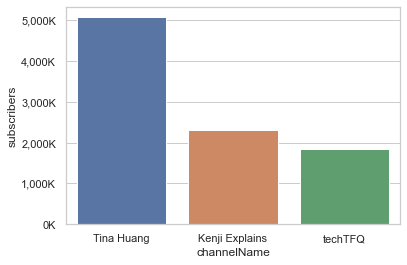

In [12]:
sns.set(style="whitegrid", color_codes=True)
subs_barplot = sns.barplot(x='channelName', y='subscribers', data=channel_data.sort_values('subscribers', ascending=False))
subs_barplot.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/100) + 'K'))

Next, we will create a bar plot to examine the total numbers of views per channel. We can see a direct correlation between the amount of subscribers and amount of views in the videos.

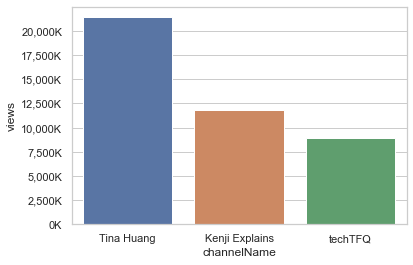

In [13]:
views_barplot = sns.barplot(x='channelName', y='views', data=channel_data.sort_values('views', ascending=False))
views_barplot.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

In [14]:
# Create a dataframe with video statistics and comments from all channels

video_df = pd.DataFrame()
comments_df = pd.DataFrame()

for c in channel_data['channelName'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = channel_data.loc[channel_data['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    
    # get video data
    video_data = get_video_details(youtube, video_ids)
    # get comment data
    comments_data = get_comments_in_videos(youtube, video_ids)

    # append video data together and comment data toghether
    video_df = video_df.append(video_data, ignore_index=True)
    comments_df = comments_df.append(comments_data, ignore_index=True)

Getting video information from channel: techTFQ


C:\Users\samso\AppData\Local\Temp\ipykernel_14724\893411185.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\samso\AppData\Local\Temp\ipykernel_14724\893411185.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Getting video information from channel: Kenji Explains


C:\Users\samso\AppData\Local\Temp\ipykernel_14724\893411185.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\samso\AppData\Local\Temp\ipykernel_14724\893411185.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


Getting video information from channel: Tina Huang


C:\Users\samso\AppData\Local\Temp\ipykernel_14724\893411185.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)
C:\Users\samso\AppData\Local\Temp\ipykernel_14724\893411185.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comments_df = comments_df.append(comments_data, ignore_index=True)


In [15]:
video_df

video_id channelTitle  \
0    7skZzocEU6c      techTFQ   
1    LZGaRcDxj8I      techTFQ   
2    rBPQ5fg_kiY      techTFQ   
3    hvwltYazuQo      techTFQ   
4    a-hFbr-4VQQ      techTFQ   
..           ...          ...   
303  mueI-I7Suxw   Tina Huang   
304  -zQ-Pf491bQ   Tina Huang   
305  Rx1i1J4m4MQ   Tina Huang   
306  JUkSeqe1eYQ   Tina Huang   
307  KsQU_3n0IYE   Tina Huang   

                                                 title  \
0    Solving a Complex SQL Interview problem | Prac...   
1    REAL SQL Interview Problem | Hierarchical data...   
2      Complete guide to Database Normalization in SQL   
3    SQL Live class on Lighthall | Learn SQL from B...   
4    How to learn SQL for free | Roadmap to learnin...   
..                                                 ...   
303  3rd Year Statistics,  Data Science, Computer S...   
304  How I Became a Data Scientist | Computer Scien...   
305  How I got Software Engineering and Data Scienc...   
306  How to choose between software engineering and...   
307                           My UPenn MCIT Experience   

                                           description  \
0    In this video, let us solve a complex SQL inte...   
1    In this video let us solve a real SQL intervie...   
2    This is a complete guide for anyone to underst...   
3    In this video, I talk about the Live SQL Class...   
4    In this video, you will find complete roadmap ...   
..                                                 ...   
303  You should watch this video if you are applyin...   
304  This is part 2 of my internship and job search...   
305  I got Amazon and Goldman Sachs internships for...   
306  Software Engineering vs Data Science? Last yea...   
307  I just graduated - yay! In this video, I talk ...   

                                                  tags           publishedAt  \
0    [sql, learn sql, sql query, sql queries, sql p...  2023-03-21T13:00:12Z   
1    [sql, learn sql, sql queries, sql query, solvi...  2023-03-14T13:00:09Z   
2    [database normalization, database normalizatio...  2023-03-07T13:00:07Z   
3    [sql, sql queries, learn sql, sql live class, ...  2023-01-26T07:00:07Z   
4    [learn sql, how to learn sql, how to learn sql...  2022-12-28T13:00:10Z   
..                                                 ...                   ...   
303  [data science resume, software engineering res...  2020-08-08T12:08:36Z   
304  [upenn, mcit, data science, software engineeri...  2020-08-02T21:44:56Z   
305  [computer science, mcit, upenn, university of ...  2020-07-28T16:48:31Z   
306  [data science, software engineering, data scie...  2020-07-22T06:00:57Z   
307  [upenn, university of pennsylvania, mcit, mast...  2020-07-17T04:53:01Z   

    viewCount likeCount favoriteCount commentCount  duration definition  \
0       15538       471             0           62   PT32M9S         hd   
1        8838       451             0           43   PT22M9S         hd   
2       17612       980             0          171  PT40M51S         hd   
3        9783       230             0          145   PT6M46S         hd   
4      191627      6711             0          296  PT27M20S         hd   
..        ...       ...           ...          ...       ...        ...   
303      6772       190             0           24  PT14M36S         hd   
304     15362       441             0           41   PT7M52S         hd   
305     29826       992             0           68   PT9M48S         hd   
306    368661     16856             0          656   PT7M56S         hd   
307     21543       351             0           74  PT13M24S         hd   

    caption  
0     false  
1     false  
2     false  
3     false  
4     false  
..      ...  
303   false  
304   false  
305   false  
306   false  
307   false  

[308 rows x 13 columns]

In [16]:
comments_df

video_id                                           comments
0    7skZzocEU6c  [What a fantastic explanation. Great job and t...
1    LZGaRcDxj8I  [Can You make a video for sending email to spe...
2    rBPQ5fg_kiY  [Thanks bro nice explanation on Normalisation....
3    hvwltYazuQo  [When is the next sql boot camp?, When is the ...
4    a-hFbr-4VQQ  [Great Video!, Bro can I work on SQL server ar...
..           ...                                                ...
303  mueI-I7Suxw  [thank you \n❤️❤️❤️❤️, 😊👍, Where was this a fe...
304  -zQ-Pf491bQ  [YAAAAY!, The honesty from this channel is awe...
305  Rx1i1J4m4MQ  [Cs internship search is stressful for everyon...
306  JUkSeqe1eYQ  [Do you resonate more with software engineerin...
307  KsQU_3n0IYE  [Hi, Thanks for the informative video! This ye...

[308 rows x 2 columns]

### Data Wrangling

Check for empty values

In [17]:
video_df.isnull().any()

video_id         False
channelTitle     False
title            False
description      False
tags              True
publishedAt      False
viewCount        False
likeCount        False
favoriteCount    False
commentCount     False
duration         False
definition       False
caption          False
dtype: bool

Check publishedAt column to verify current format

In [18]:
video_df.publishedAt.sort_values().value_counts()

2020-06-22T14:49:50Z    1
2022-04-22T14:30:00Z    1
2022-05-15T14:45:01Z    1
2022-05-08T14:45:00Z    1
2022-05-07T12:00:03Z    1
                       ..
2021-07-11T14:45:01Z    1
2021-07-07T14:45:01Z    1
2021-07-05T12:00:04Z    1
2021-07-04T17:30:03Z    1
2023-04-02T17:45:00Z    1
Name: publishedAt, Length: 308, dtype: int64

Check column types

In [19]:
video_df.dtypes

video_id         object
channelTitle     object
title            object
description      object
tags             object
publishedAt      object
viewCount        object
likeCount        object
favoriteCount    object
commentCount     object
duration         object
definition       object
caption          object
dtype: object

In [20]:
#Fixed column types for viewCount, likeCount, favoriteCount, commentCount
cols = ['viewCount', 'likeCount', 'favoriteCount', 'commentCount']
video_df[cols] = video_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [21]:
# Create publish day (in the week) column
video_df['publishedAt'] =  video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 

In [22]:
# convert duration to seconds
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [23]:
# Add number of tags
video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [24]:
# Comments and likes per 100 view ratio
video_df['likeRatio'] = video_df['likeCount']/ video_df['viewCount'] * 100
video_df['commentRatio'] = video_df['commentCount']/ video_df['viewCount'] * 100

Let's check the video dataset to review changes made

In [25]:
video_df.head()

video_id channelTitle  \
0  7skZzocEU6c      techTFQ   
1  LZGaRcDxj8I      techTFQ   
2  rBPQ5fg_kiY      techTFQ   
3  hvwltYazuQo      techTFQ   
4  a-hFbr-4VQQ      techTFQ   

                                               title  \
0  Solving a Complex SQL Interview problem | Prac...   
1  REAL SQL Interview Problem | Hierarchical data...   
2    Complete guide to Database Normalization in SQL   
3  SQL Live class on Lighthall | Learn SQL from B...   
4  How to learn SQL for free | Roadmap to learnin...   

                                         description  \
0  In this video, let us solve a complex SQL inte...   
1  In this video let us solve a real SQL intervie...   
2  This is a complete guide for anyone to underst...   
3  In this video, I talk about the Live SQL Class...   
4  In this video, you will find complete roadmap ...   

                                                tags  \
0  [sql, learn sql, sql query, sql queries, sql p...   
1  [sql, learn sql, sql queries, sql query, solvi...   
2  [database normalization, database normalizatio...   
3  [sql, sql queries, learn sql, sql live class, ...   
4  [learn sql, how to learn sql, how to learn sql...   

                publishedAt  viewCount  likeCount  favoriteCount  \
0 2023-03-21 13:00:12+00:00      15538        471              0   
1 2023-03-14 13:00:09+00:00       8838        451              0   
2 2023-03-07 13:00:07+00:00      17612        980              0   
3 2023-01-26 07:00:07+00:00       9783        230              0   
4 2022-12-28 13:00:10+00:00     191627       6711              0   

   commentCount  duration definition caption pushblishDayName  durationSecs  \
0            62   PT32M9S         hd   false          Tuesday        1929.0   
1            43   PT22M9S         hd   false          Tuesday        1329.0   
2           171  PT40M51S         hd   false          Tuesday        2451.0   
3           145   PT6M46S         hd   false         Thursday         406.0   
4           296  PT27M20S         hd   false        Wednesday        1640.0   

   tagsCount  likeRatio  commentRatio  
0         15   3.031278      0.399022  
1         22   5.102964      0.486535  
2         27   5.564388      0.970929  
3         16   2.351017      1.482163  
4         16   3.502116      0.154467

### Exploratory Analysis

We analyze the views distribution per channel. This indicates that Tina Huang has had more videos that have gone viral and the rest do not have as many views. With techTFQ and Kenji Explains we see a more even views distribution, although they also have some videos that had more views

C:\Users\samso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


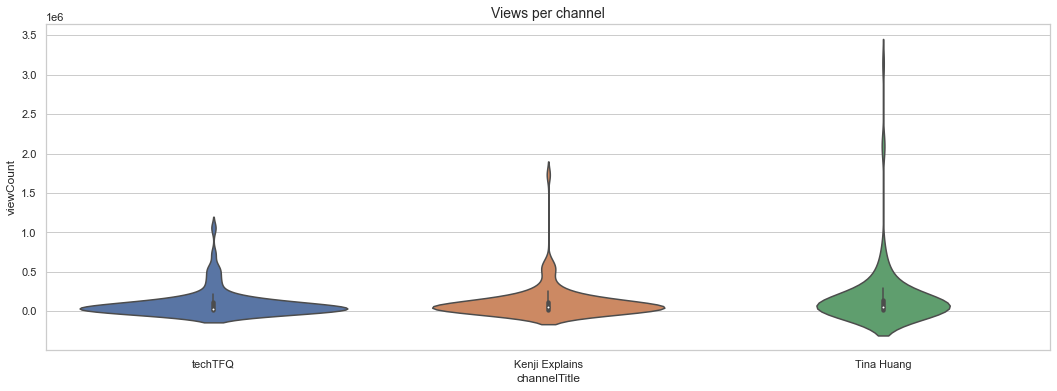

In [26]:
plt.rcParams['figure.figsize'] = (18, 6)
sns.violinplot(video_df['channelTitle'], video_df['viewCount'])
plt.title('Views per channel', fontsize = 14)
plt.show()

#### Number of likes/comments vs views

We see a direct correlation with the comments vs views and same with like count vs views

In [27]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeCount", y = "viewCount", ax=ax[1])

<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

In [28]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentRatio", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeRatio", y = "viewCount", ax=ax[1])

<AxesSubplot:xlabel='likeRatio', ylabel='viewCount'>

#### Video duration vs likes/comments

In [29]:
sns.histplot(data=video_df[video_df['durationSecs'] < 10000], x="durationSecs", bins=30)

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

In [30]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "durationSecs", y = "likeCount", ax=ax[1])

<AxesSubplot:xlabel='durationSecs', ylabel='likeCount'>

### Wordcloud for words in title

In [31]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

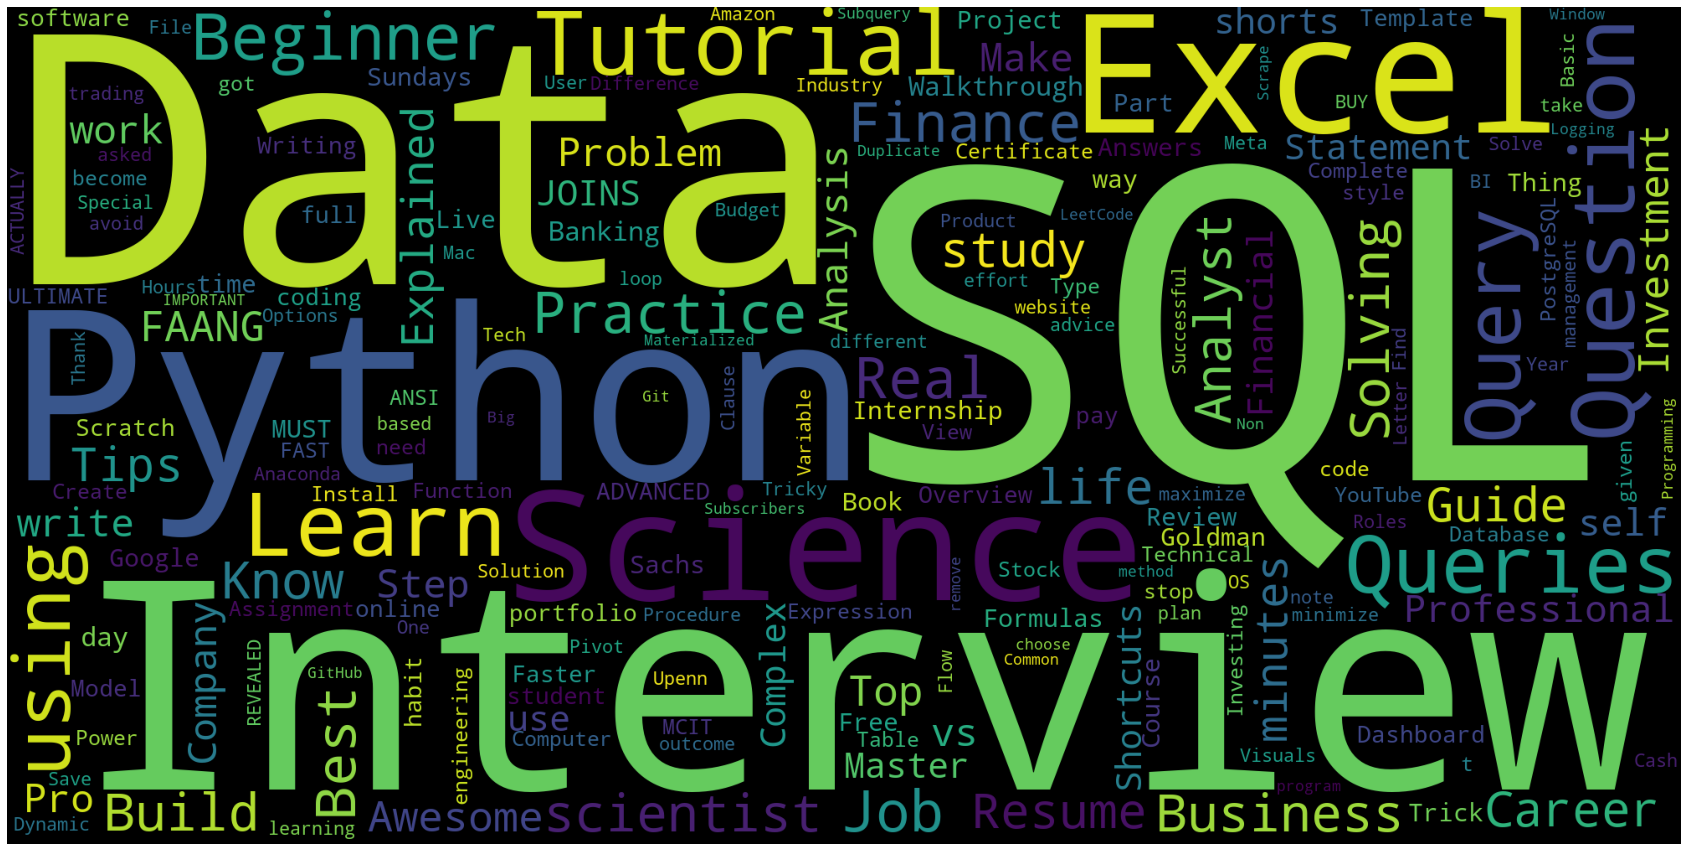

In [32]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

#### Number of tags

<AxesSubplot:xlabel='tagsCount', ylabel='viewCount'>

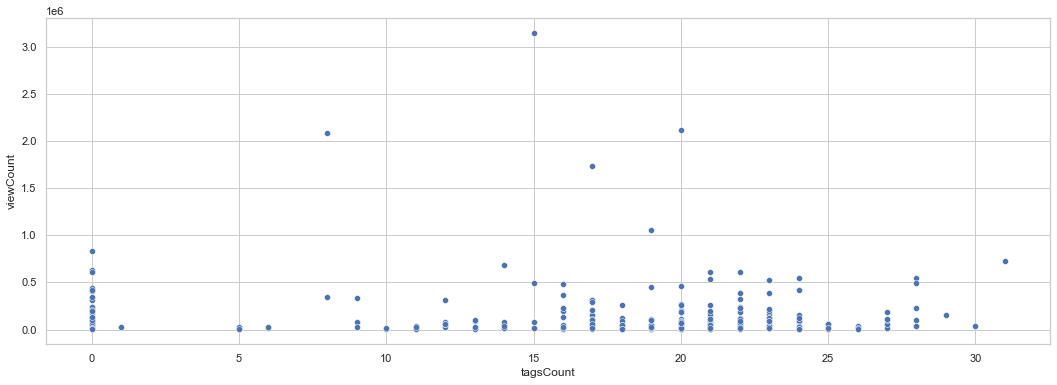

In [33]:
sns.scatterplot(data = video_df, x = "tagsCount", y = "viewCount")

#### Day of the week with the most uploads

We see a lopsided plot with Sunday being the preferred day for upload videos. 

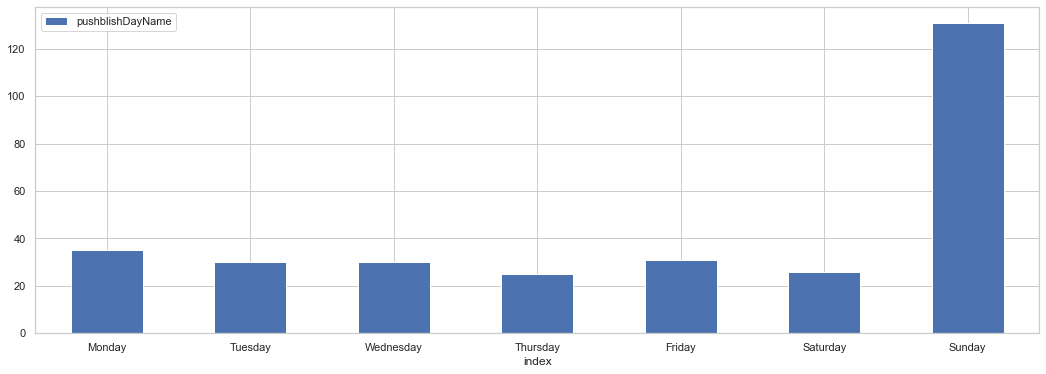

In [34]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)